이 코드는 다음의 reference의 코드를 가져왔습니다.


ref1: https://github.com/AndreyTulyakov/Simple-U-net-Example

ref2: https://www.tensorflow.org/tutorials/images/segmentation


In [1]:
#이미지와 annotations을 복사
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz #이미지를 다운로드
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz #annotations를 다운로드

--2021-02-05 03:32:34--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  35.0MB/s    in 22s     

2021-02-05 03:32:56 (34.1 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2021-02-05 03:32:57--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  18.2MB/s    in 1.0s    

2021-02-05 03:32:58 (18.2 M

In [2]:
# images.tar.gz파일 앞축풀기
!tar -xf images.tar.gz

# annotations.tar.gz파일 압축풀기
!tar -xf annotations.tar.gz

In [3]:
ls

annotations/  annotations.tar.gz  images/  images.tar.gz  sample_data/


In [4]:
# 기본 세팅
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate 
from tensorflow.keras.layers import Dense,  Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image # pip install pillow

import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
#GPU메모리 부족현상을 해결하기 위해
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
# oxford_pets 데이터파일을 열어서 test dataset과 training dataset만드는 함수
def load_oxford_pets_2(target_size= (128, 128), test_split_rate= 0.2):
    input_file = "./annotations/list.txt"
    file = open(input_file)
    list_txt = file.readlines()
    file.close()
    
    list_txt = list_txt[6:]     # delete header
    np.random.shuffle(list_txt)

    # load dataset
    dataset = {"name": [], "label": [], "image": [ ], "mask": [] }
    for line in list_txt:
        image_name, class_id, species,  breed_id = line.split()
        image_file= "./images/"+ image_name + ".jpg"
        mask_file = "./annotations/trimaps/"+ image_name + ".png"

        if os.path.exists(image_file) and os.path.exists(mask_file):
            dataset["name"].append(image_name)
            dataset["label"].append(int(species)-1) # Cat: 0, Dog: 1

            # read image and scale to target_size
            img = image.load_img(image_file, target_size=target_size)
            img = image.img_to_array(img)  # (128, 128, 3)
            dataset["image"].append(img)

            # read mask
            mask = image.load_img(mask_file, target_size= target_size,
                                             color_mode='grayscale')    
            mask = image.img_to_array(mask) # (128, 128, 1)
            dataset["mask"].append(mask)

    # change list to np.array
    dataset["name"]  = np.array(dataset["name"])
    dataset["label"] = np.array(dataset["label"])
    dataset["image"] = np.array(dataset["image"])    
    dataset["mask"]  = np.array(dataset["mask"])
    
    # split dataset into train_dataset and test_dataset
    dataset_total = dataset['image'].shape[0]
    test_size     = int(dataset_total*test_split_rate)
    train_size    = dataset_total - test_size

    train_dataset = {}
    train_dataset["name"]= dataset["name"][:train_size]
    train_dataset["label"]= dataset["label"][:train_size]
    train_dataset["image"]= dataset["image"][:train_size]
    train_dataset["mask"]= dataset["mask"][:train_size]
    
    test_dataset  = {}    
    test_dataset["name"] = dataset["name"][train_size:]
    test_dataset["label"]= dataset["label"][train_size:]
    test_dataset["image"]= dataset["image"][train_size:]
    test_dataset["mask"]= dataset["mask"][train_size:]     
    return train_dataset, test_dataset

In [7]:
# dataset loading
train_dataset, test_dataset = load_oxford_pets_2() # target_size= (128, 128)
print("train_dataset['image'].shape=", train_dataset['image'].shape)# (5880, 128, 128, 3)
print("test_dataset['image'].shape=",  test_dataset['image'].shape) # (1469, 128, 128, 3)

x_train = train_dataset["image"]/255.0
x_test = test_dataset["image"]/255.0

y_train = train_dataset["mask"]-1 # [1, 2, 3] -> [0, 1, 2]
y_test = test_dataset["mask"]-1
print("x_train.shape = ", x_train.shape)
print("y_train.shape = ", y_train.shape)

train_dataset['image'].shape= (5880, 128, 128, 3)
test_dataset['image'].shape= (1469, 128, 128, 3)
x_train.shape =  (5880, 128, 128, 3)
y_train.shape =  (5880, 128, 128, 1)


In [8]:
display([x_train[100], y_train[100]])

[array([[[0.40392157, 0.19607843, 0.07450981],
         [0.3647059 , 0.1764706 , 0.08627451],
         [0.2627451 , 0.12156863, 0.07450981],
         ...,
         [0.01568628, 0.03137255, 0.04313726],
         [0.01176471, 0.02745098, 0.03137255],
         [0.01960784, 0.03529412, 0.03921569]],
 
        [[0.40392157, 0.20392157, 0.09803922],
         [0.39215687, 0.19215687, 0.08627451],
         [0.39215687, 0.1882353 , 0.09411765],
         ...,
         [0.        , 0.01568628, 0.02745098],
         [0.00784314, 0.02352941, 0.02745098],
         [0.01176471, 0.02745098, 0.03137255]],
 
        [[0.39607844, 0.19607843, 0.09019608],
         [0.40784314, 0.20392157, 0.10980392],
         [0.41960785, 0.21568628, 0.12941177],
         ...,
         [0.01568628, 0.01960784, 0.02745098],
         [0.00392157, 0.01960784, 0.02352941],
         [0.00392157, 0.01960784, 0.02352941]],
 
        ...,
 
        [[0.17254902, 0.08627451, 0.04313726],
         [0.15294118, 0.05882353, 0.01960

In [9]:
#UNet 구조 정의
def unet_1(input_shape=(128, 128, 3), num_classes=3):
  
    inputs = Input(shape=input_shape)
    # 128
    
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPool2D()(down1)
    # 64

    center = Conv2D(512, (3, 3), activation='relu', padding='same')(down1_pool)
    center = BatchNormalization()(center)
    center = Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    center = BatchNormalization()(center)
    # center

    up1 = UpSampling2D((2, 2))(center)
    up1 = concatenate([down1, up1], axis=3) # try comment this line, i.e, without this shotcut
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(up1)   
    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=RMSprop(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])    
    return model

#4:
UNET = unet_1()

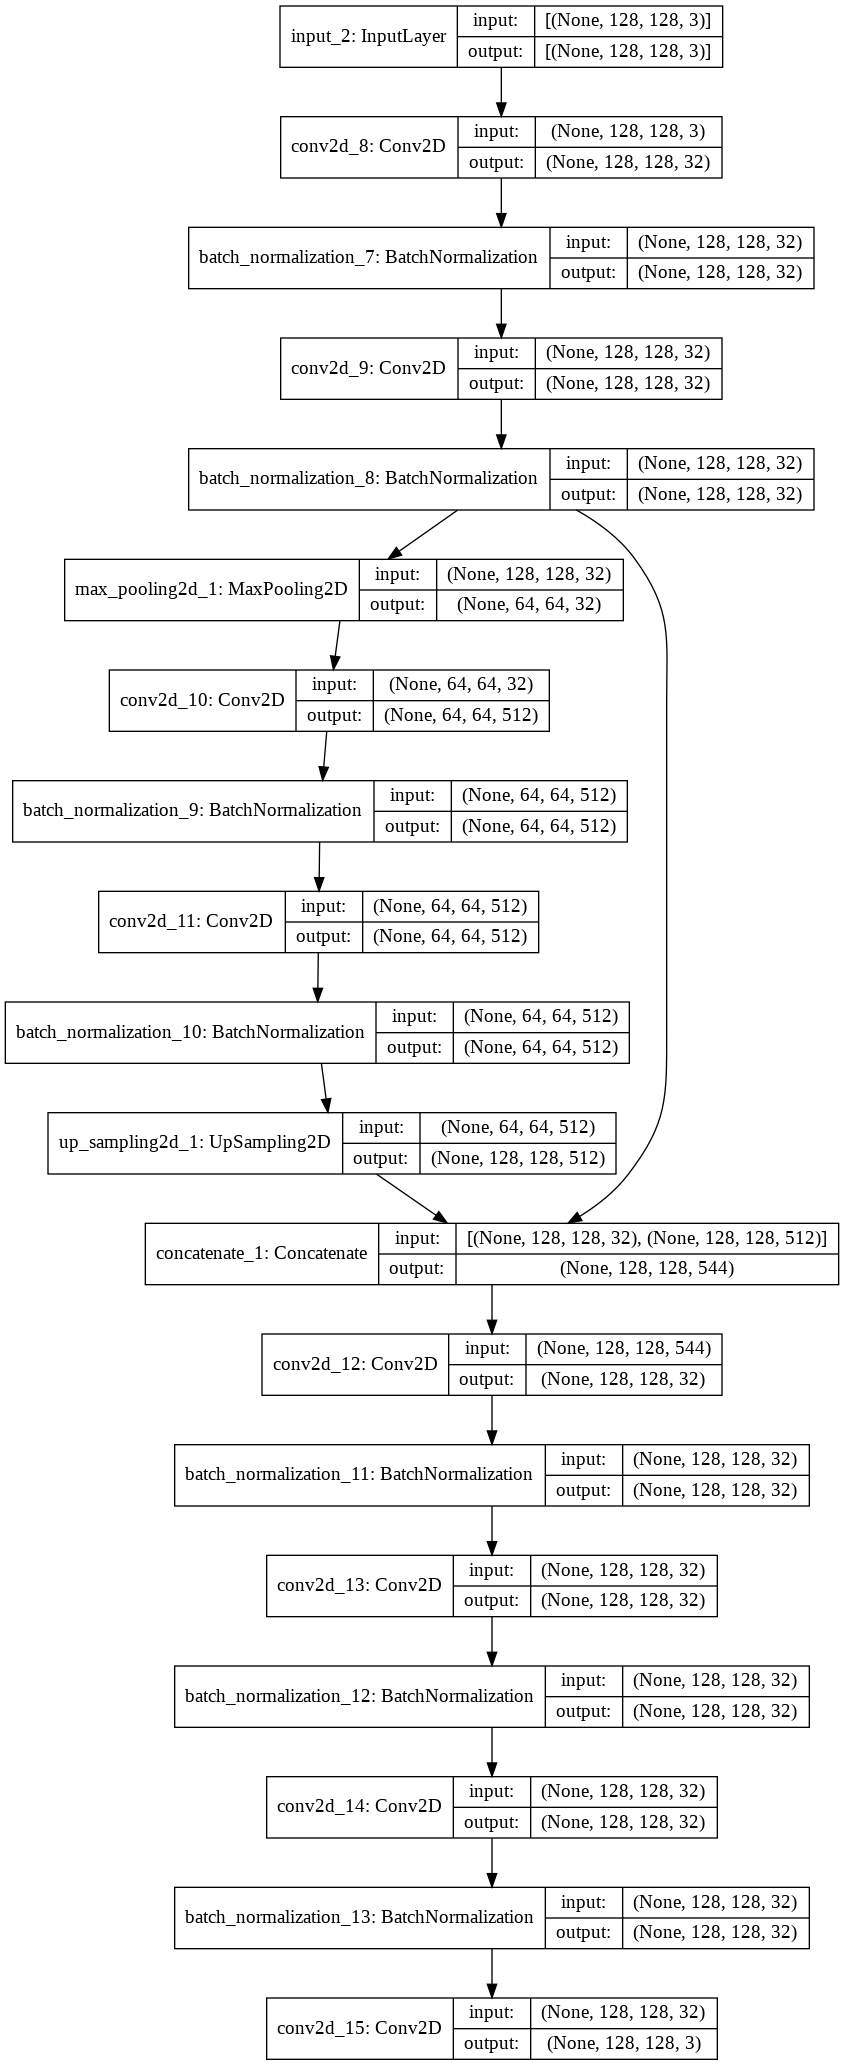

In [ ]:
tf.keras.utils.plot_model(UNET, show_shapes=True)

Epoch 1/20
735/735 - 103s - loss: 0.6983 - accuracy: 0.6981
Epoch 2/20
735/735 - 99s - loss: 0.5618 - accuracy: 0.7691
Epoch 3/20
735/735 - 98s - loss: 0.5216 - accuracy: 0.7885
Epoch 4/20
735/735 - 98s - loss: 0.4994 - accuracy: 0.7982
Epoch 5/20
735/735 - 98s - loss: 0.4843 - accuracy: 0.8045
Epoch 6/20
735/735 - 98s - loss: 0.4742 - accuracy: 0.8093
Epoch 7/20
735/735 - 98s - loss: 0.4605 - accuracy: 0.8159
Epoch 8/20
735/735 - 98s - loss: 0.4535 - accuracy: 0.8188
Epoch 9/20
735/735 - 98s - loss: 0.4470 - accuracy: 0.8213
Epoch 10/20
735/735 - 98s - loss: 0.4375 - accuracy: 0.8258
Epoch 11/20
735/735 - 97s - loss: 0.4309 - accuracy: 0.8285
Epoch 12/20
735/735 - 98s - loss: 0.4245 - accuracy: 0.8316
Epoch 13/20
735/735 - 98s - loss: 0.4213 - accuracy: 0.8326
Epoch 14/20
735/735 - 97s - loss: 0.4158 - accuracy: 0.8352
Epoch 15/20
735/735 - 97s - loss: 0.4106 - accuracy: 0.8372
Epoch 16/20
735/735 - 98s - loss: 0.4056 - accuracy: 0.8396
Epoch 17/20
735/735 - 98s - loss: 0.4024 - accur

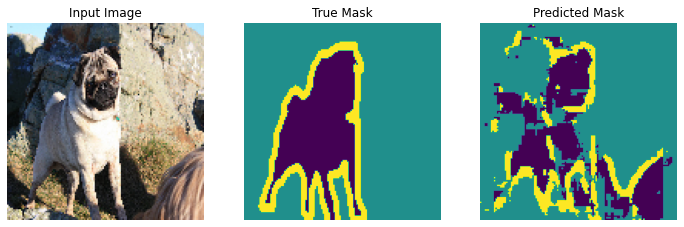

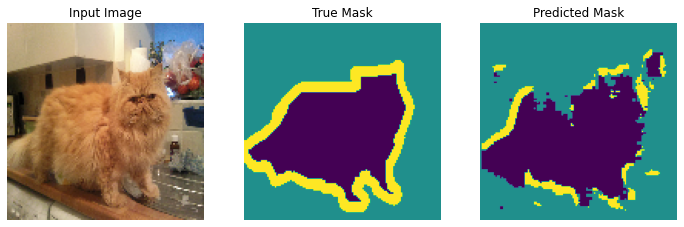

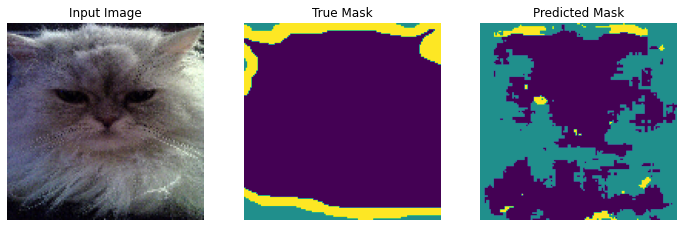

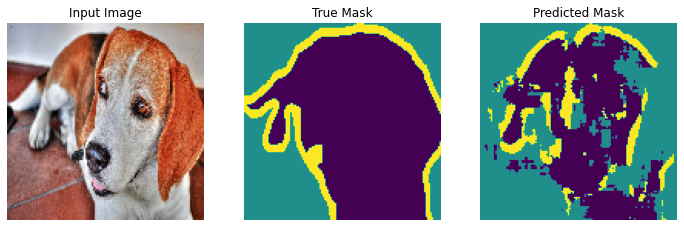

In [10]:
ret = UNET.fit(x_train, y_train, epochs = 20, batch_size = 8, verbose = 2)
'''message:
tensorflow.python.framework.errors_impl.ResourceExhaustedError:  OOM when allocating tensor

solution: reduce batch_size to  8, 4, 2...
'''
train_loss, train_acc = UNET.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc   = UNET.evaluate(x_test,  y_test, verbose=2)

#5:
def display(display_list):
  plt.figure(figsize=(12, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
#6:  
def create_mask(pred_mask):  # (:, 128, 128, 3)
  pred_mask = tf.argmax(pred_mask, axis=-1) # (:, 128, 128), axis=3 
  pred_mask = pred_mask[..., tf.newaxis]    # (:, 128, 128, 1) 
  return pred_mask

# predict segmentation of train data
k = 2
pred_mask = UNET.predict(x_train[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)     # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_train[i], y_train[i], pred_mask[i]])

#7: predict segmentation of test dat
pred_mask = UNET.predict(x_test[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)    # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_test[i], y_test[i], pred_mask[i]])    

In [11]:
#3: ref1
def unet_2(input_shape=(128, 128, 3), num_classes=3):
  
    inputs = Input(shape=input_shape)
    # 128
    
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(32, (3, 3), activation='relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPool2D()(down1)
    # 64
    
    down2 = Conv2D(64, (3, 3), activation='relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(64, (3, 3), activation='relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPool2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(128, (3, 3), activation='relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(128, (3, 3), activation='relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPool2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(256, (3, 3), activation='relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(256, (3, 3), activation='relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPool2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(512, (3, 3), activation='relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(512, (3, 3), activation='relu', padding='same')(center)
    center = BatchNormalization()(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    
    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)

    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)

    up4 = Conv2D(256, (3, 3), activation='relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)    
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    # 128

    classify = Conv2D(3, (1, 1), padding='same', activation='sigmoid')(up1)   
    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=RMSprop(0.001),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])    
    return model

In [13]:
#4:
UNET = unet_2()
UNET.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 128, 128, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 128, 128, 32) 128         conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization_7[0][0]      
____________________________________________________________________________________________

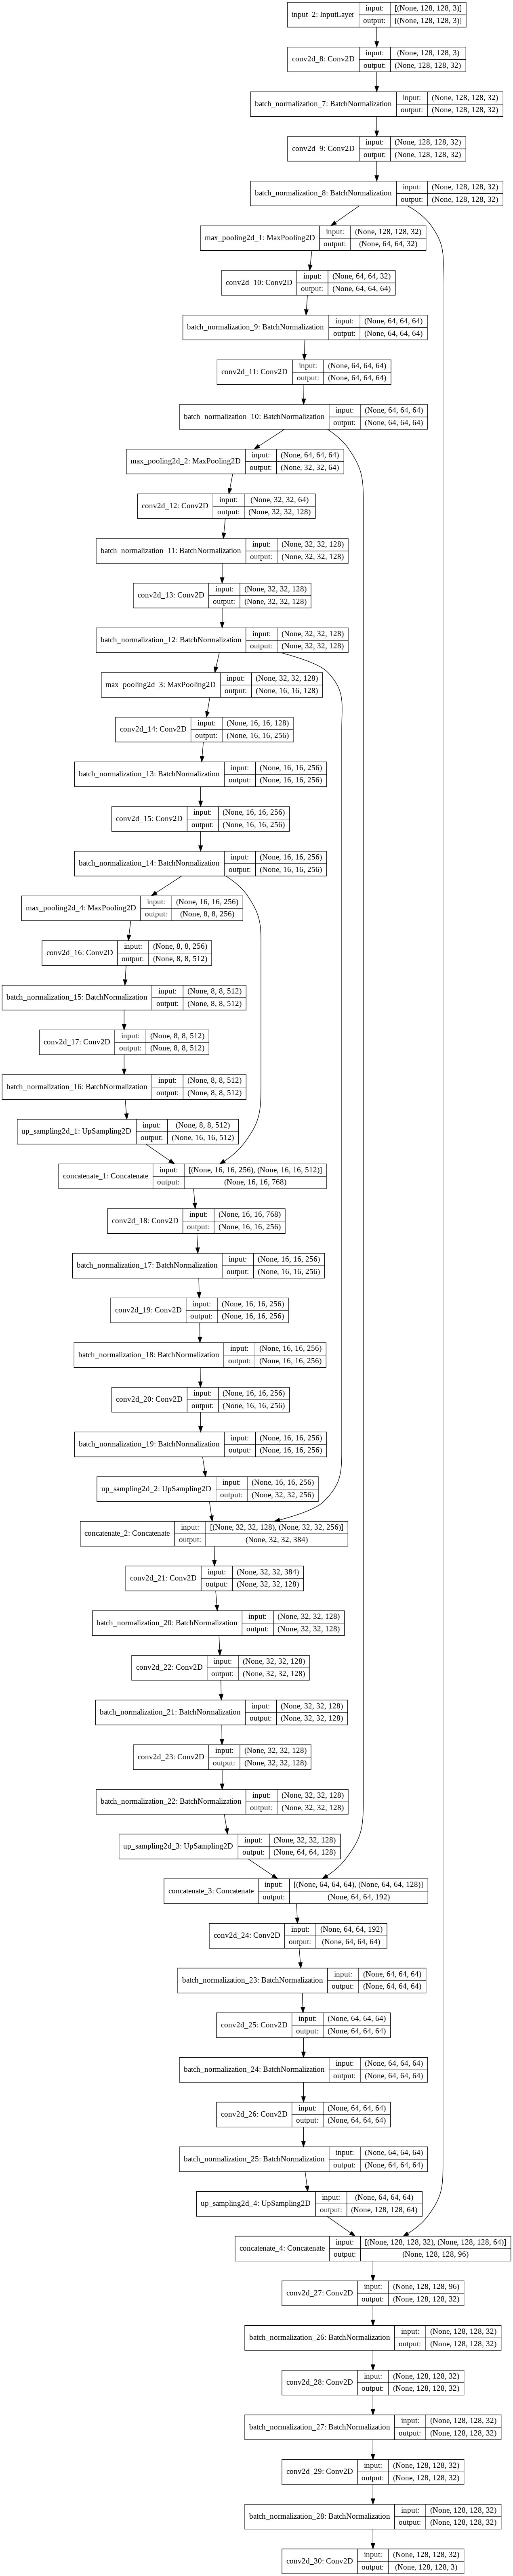

In [14]:
tf.keras.utils.plot_model(UNET, show_shapes=True)

Epoch 1/20
735/735 - 53s - loss: 0.6221 - accuracy: 0.7451
Epoch 2/20
735/735 - 47s - loss: 0.4344 - accuracy: 0.8312
Epoch 3/20
735/735 - 48s - loss: 0.3804 - accuracy: 0.8533
Epoch 4/20
735/735 - 48s - loss: 0.3481 - accuracy: 0.8666
Epoch 5/20
735/735 - 48s - loss: 0.3235 - accuracy: 0.8756
Epoch 6/20
735/735 - 48s - loss: 0.3013 - accuracy: 0.8855
Epoch 7/20
735/735 - 48s - loss: 0.2809 - accuracy: 0.8934
Epoch 8/20
735/735 - 48s - loss: 0.2658 - accuracy: 0.8991
Epoch 9/20
735/735 - 48s - loss: 0.2527 - accuracy: 0.9041
Epoch 10/20
735/735 - 48s - loss: 0.2403 - accuracy: 0.9084
Epoch 11/20
735/735 - 48s - loss: 0.2275 - accuracy: 0.9128
Epoch 12/20
735/735 - 48s - loss: 0.2186 - accuracy: 0.9159
Epoch 13/20
735/735 - 48s - loss: 0.2104 - accuracy: 0.9185
Epoch 14/20
735/735 - 48s - loss: 0.2000 - accuracy: 0.9223
Epoch 15/20
735/735 - 48s - loss: 0.1921 - accuracy: 0.9251
Epoch 16/20
735/735 - 48s - loss: 0.1845 - accuracy: 0.9276
Epoch 17/20
735/735 - 48s - loss: 0.1787 - accura

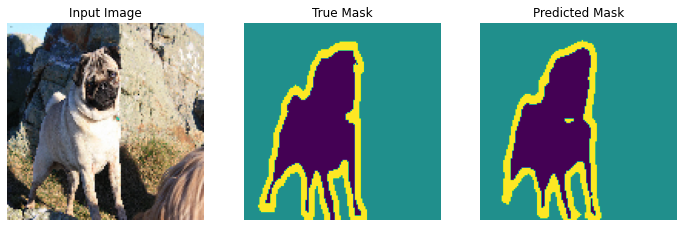

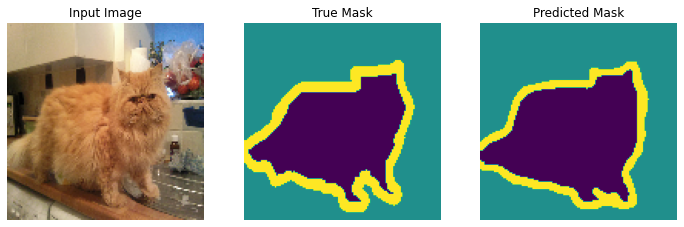

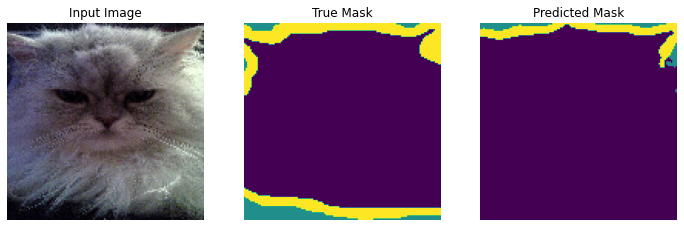

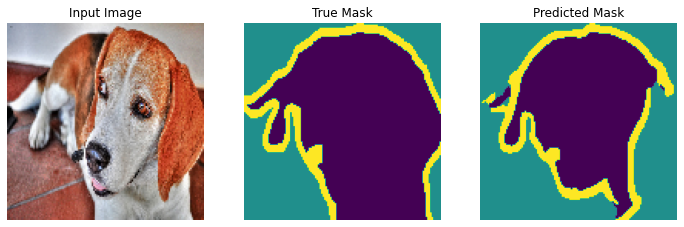

In [15]:
ret = UNET.fit(x_train, y_train, epochs = 20, batch_size = 8, verbose = 2)
'''message:
tensorflow.python.framework.errors_impl.ResourceExhaustedError:  OOM when allocating tensor

solution: reduce batch_size to  8, 4, 2...
'''
train_loss, train_acc = UNET.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc   = UNET.evaluate(x_test,  y_test, verbose=2)

#5:
def display(display_list):
  plt.figure(figsize=(12, 4))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()
  
#6:  
def create_mask(pred_mask):  # (:, 128, 128, 3)
  pred_mask = tf.argmax(pred_mask, axis=-1) # (:, 128, 128), axis=3 
  pred_mask = pred_mask[..., tf.newaxis]    # (:, 128, 128, 1) 
  return pred_mask

# predict segmentation of train data
k = 2
pred_mask = UNET.predict(x_train[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)     # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_train[i], y_train[i], pred_mask[i]])

#7: predict segmentation of test dat
pred_mask = UNET.predict(x_test[:k])  # pred_mask.shape = (k, 128, 128, 3)
pred_mask = create_mask(pred_mask)    # TensorShape([k, 128, 128, 1])

for i in range(k):
    display([x_test[i], y_test[i], pred_mask[i]]) 